In [1]:
import os, sys, gzip
import cPickle as pickle
sys.setrecursionlimit(10000)

import numpy as np
np.random.seed(1004)   # for reproducibility
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
%matplotlib inline
from scipy.misc import imresize

import pandas as pd
import h5py

from lasagne import layers, nonlinearities, updates, objectives, init, regularization
from lasagne.layers import get_output, get_output_shape, get_all_params
import theano.tensor as T
import theano
#from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.shared_randomstreams import RandomStreams


Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)


In [2]:
datapath='/home/peter/Data/CMAP/training.csv'
savepath='/home/peter/Data/CMAP/data.hd5f'

f = h5py.File(savepath, "w")
batch_size = 30000
shuffle_index = np.random.permutation(100000)
for i in range(3):
    batch_index =range(i*batch_size, (i+1)*batch_size)
    data = pd.read_csv(datapath, usecols=shuffle_index[batch_index], header=None, dtype=np.float32)
    genes = data.as_matrix()
    num_landmark = 970
    num_nonlandmark = 11350
    num_samples = genes.shape[1]
    landmark = genes[:970,:]
    nonlandmark = genes[970:,:]
    del genes

    dset = f.create_dataset("landmark"+str(i), data=landmark)
    dset = f.create_dataset("nonlandmark"+str(i), data=nonlandmark)
    del landmark
    del nonlandmark

batch_index =range(3*batch_size, 100000)
data = pd.read_csv(datapath, usecols=shuffle_index[batch_index], header=None, dtype=np.float32)
genes = data.as_matrix()
num_landmark = 970
num_nonlandmark = 11350
num_samples = genes.shape[1]
landmark = genes[:970,:]
nonlandmark = genes[970:,:]
del genes

dset = f.create_dataset("landmark3", data=landmark)
dset = f.create_dataset("nonlandmark3", data=nonlandmark)
del landmark
del nonlandmark

f.close()

In [5]:

def normalize_data(landmark, mean_landmark, std_landmark, num_samples):
    landmark = (landmark - np.outer(mean_landmark,np.ones(num_samples)))/np.outer(std_landmark,np.ones(num_samples))
    landmark = landmark.transpose([1,0])
    
    return landmark


filepath='/home/peter/Data/CMAP/data.hd5f'
trainmat = h5py.File(filepath, 'r')
landmark= np.array(trainmat['landmark1']).astype(np.float32)
nonlandmark = np.array(trainmat['nonlandmark1']).astype(np.float32)

num_files = 4
mean_landmark = 0
std_landmark = 0
mean_nonlandmark = 0
std_nonlandmark = 0
for i in range(num_files):
    landmark= np.array(trainmat['landmark'+str(i)]).astype(np.float32)
    nonlandmark = np.array(trainmat['nonlandmark'+str(i)]).astype(np.float32)
    mean_landmark += np.mean(landmark, axis=1)
    std_landmark += np.std(landmark,axis=1)
    mean_nonlandmark += np.mean(nonlandmark, axis=1)
    std_nonlandmark += np.std(nonlandmark, axis=1)

mean_landmark /= num_files
std_landmark /= num_files
mean_nonlandmark /= num_files
std_nonlandmark /= num_files



In [6]:
mean_landmark = (mean_landmark + np.mean(landmark,axis=1))/2
std_landmark = (std_landmark + np.std(landmark, axis=1))/2

savepath='/home/peter/Data/CMAP/data_norm.hd5f'
f = h5py.File(savepath, "w")
for i in range(4):
    landmark = np.array(trainmat['landmark'+str(i)]).astype(np.float32)
    nonlandmark = np.array(trainmat['nonlandmark'+str(i)]).astype(np.float32)
    landmark = normalize_data(landmark, mean_landmark, std_landmark, landmark.shape[1])
    dset = f.create_dataset("landmark"+str(i), data=landmark)
    dset = f.create_dataset("nonlandmark"+str(i), data=nonlandmark)
dset = f.create_dataset("mean_landmark", data=mean_landmark)
dset = f.create_dataset("std_landmark", data=std_landmark)
dset = f.create_dataset("mean_nonlandmark", data=mean_nonlandmark)
dset = f.create_dataset("std_nonlandmark", data=std_nonlandmark)
f.close()


In [ ]:
filepath='/home/peter/Data/CMAP/dataset_norm.hd5f'
trainmat = h5py.File(filepath, 'r')
landmark= np.array(trainmat['landmark4']).astype(np.float32)
nonlandmark = np.array(trainmat['nonlandmark4']).astype(np.float32)

In [ ]:
index = 2
plt.hist(landmark[:,index]);

In [ ]:
C = np.cov(nonlandmark.T)

In [ ]:
plt.imshow(C)
plt.colorbar()

# linear regression

In [ ]:
input_var = T.dmatrix('inputs')
shape = (None, landmark.shape[1])
net = {}
net['input'] = layers.InputLayer(shape=shape, input_var=input_var)
net['dense1'] = layers.DenseLayer(net['input'], num_units=nonlandmark.shape[1], W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=None)
net['dense1_active'] = layers.NonlinearityLayer(net['dense1'], nonlinearity=nonlinearities.linear)
net['output'] = net['dense1_active']

In [ ]:
target_var = T.dmatrix('inputs')
prediction = get_output(net['output'], deterministic=False )
loss = objectives.squared_error(target_var, prediction)
loss = objectives.aggregate(loss, mode='mean')

# ADAM updates
params = get_all_params(net['output'], trainable=True)
update_op = updates.adam(loss, params, learning_rate=1e-3)

train_fun = theano.function([input_var, target_var], loss , updates=update_op, allow_input_downcast=True)


In [ ]:
def batch_generator(X, y, batch_size=128):
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt], y[excerpt]

batch_size = 100        
num_samples = 20000
num_files = 5        
num_epochs = 60    
num_batches = num_samples // batch_size
for epoch in range(num_epochs):
    sys.stdout.write("\rEpoch %d \n"%(epoch+1))

    train_loss = 0
    for i in range(num_files):
        sys.stdout.write("\r  File %d \n"%(i+1))
        landmark= np.array(trainmat['landmark'+str(i)]).astype(np.float32)
        nonlandmark = np.array(trainmat['nonlandmark'+str(i)]).astype(np.float32)
        batches = batch_generator(landmark, nonlandmark, batch_size)
        
        loss = 0
        for i in range(num_batches):
            X, y = next(batches)
            loss += train_fun(X, y)
        print("    training loss:\t\t{:.6f}".format(loss/num_batches))    
        train_loss += loss/num_batches              
    train_loss /= num_files
    print("  training loss:\t\t{:.6f}".format(train_loss))

Epoch 1 
  File 1 
    training loss:		0.588965
  File 2 
    training loss:		0.599399
  File 3 
    training loss:		0.509065
  File 4 
    training loss:		0.578905
  File 5 
    training loss:		0.566761
  training loss:		0.568619
Epoch 2 
  File 1 
    training loss:		0.464421
  File 2 
    training loss:		0.486734
  File 3 
    training loss:		0.432946
  File 4 
    training loss:		0.476401
  File 5 
    training loss:		0.494727
  training loss:		0.471046
Epoch 3 
  File 1 
    training loss:		0.448270
  File 2 
    training loss:		0.484055
  File 3 
    training loss:		0.431769
  File 4 
    training loss:		0.487850
  File 5 
    training loss:		0.504944
  training loss:		0.471378

# Feed forward network

In [ ]:
num_encode=100

input_var = T.dmatrix('inputs')
shape = (None, landmark.shape[1])
net = {}
net['input'] = layers.InputLayer(shape=shape, input_var=input_var)
net['dense1'] = layers.DenseLayer(net['input'], num_units=5000, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=None)
net['dense1_active'] = layers.NonlinearityLayer(net['dense1'], nonlinearity=nonlinearities.rectify)
#net['dense1_active'] = layers.ParametricRectifierLayer(net['dense1_norm'])
#net['dense1_droput'] = layers.DropoutLayer(net['dense1_active'], p=0.5)


net['dense2'] = layers.DenseLayer(net['dense1_active'], num_units=nonlandmark.shape[1], W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=None)
net['dense2_active'] = layers.NonlinearityLayer(net['dense2'], nonlinearity=nonlinearities.linear)
#net['dense2_active'] = layers.ParametricRectifierLayer(net['dense2_norm'])
#net['dense2_droput'] = layers.DropoutLayer(net['dense2_active'], p=0.5)

net['output'] = net['dense2_active']

In [ ]:
target_var = T.dmatrix('inputs')
prediction = get_output(net['output'], deterministic=False )
loss = objectives.squared_error(target_var, prediction)
loss = objectives.aggregate(loss, mode='mean')

#l1_penalty = regularization.regularize_network_params(net, regularization.l1) * 1e-5
#loss += l1_penalty
#l2_penalty = regularization.regularize_network_params(net, regularization.l2) * 1e-6    
#loss += l2_penalty 
    
# ADAM updates
params = get_all_params(net['output'], trainable=True)
update_op = updates.adam(loss, params, learning_rate=1e-3)

train_fun = theano.function([input_var, target_var], loss , updates=update_op, allow_input_downcast=True)

In [ ]:
def batch_generator(X, y, batch_size=128):
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt], y[excerpt]

batch_size = 100        
num_samples = 20000
num_files = 5        
num_epochs = 60    
num_batches = num_samples // batch_size
for epoch in range(num_epochs):
    sys.stdout.write("\rEpoch %d \n"%(epoch+1))

    train_loss = 0
    for i in range(num_files):
        sys.stdout.write("\r  File %d \n"%(i+1))
        landmark= np.array(trainmat['landmark'+str(i)]).astype(np.float32)
        nonlandmark = np.array(trainmat['nonlandmark'+str(i)]).astype(np.float32)
        batches = batch_generator(landmark, nonlandmark, batch_size)
        
        loss = 0
        for i in range(num_batches):
            X, y = next(batches)
            loss += train_fun(X, y)
        print("    training loss:\t\t{:.6f}".format(loss/num_batches))    
        train_loss += loss/num_batches              
    train_loss /= num_files
    print("  training loss:\t\t{:.6f}".format(train_loss))

# denoising autoencoder

In [ ]:
input_var = T.dmatrix('inputs')
shape = (None, landmark.shape[1])
net = {}
net['input'] = layers.InputLayer(shape=shape, input_var=input_var)

# encode layer 1
net['corrupt1'] = layers.GaussianNoiseLayer(net['input'], sigma=0.1)
net['encode1'] = layers.DenseLayer(net['corrupt1'], num_units=2000, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=None)
net['encode1_active'] = layers.NonlinearityLayer(net['encode1'], nonlinearity=nonlinearities.rectify)

# encode layer 2
net['corrupt2'] = layers.GaussianNoiseLayer(net['encode1_active'], sigma=0.1)
net['encode2'] = layers.DenseLayer(net['corrupt2'], num_units=4000, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=None)
net['encode2_active'] = layers.NonlinearityLayer(net['encode2'], nonlinearity=nonlinearities.rectify)

# encode layer
net['encode'] = layers.DenseLayer(net['encode2_active'], num_units=nonlandmark.shape[1], W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=None)
net['encode_active'] = layers.NonlinearityLayer(net['encode'], nonlinearity=nonlinearities.linear)

# decode layer
net['decode'] = layers.DenseLayer(net['encode_active'], num_units=4000, W=net['encode'].W.T, 
                                  b=init.Constant(.0), nonlinearity=None)
net['decode_active'] = layers.NonlinearityLayer(net['decode'], nonlinearity=nonlinearities.rectify)

# decode layer 1
net['decode1'] = layers.DenseLayer(net['decode_active'], num_units=2000, W=net['encode2'].W.T, 
                                  b=init.Constant(.0), nonlinearity=None)
net['decode1_active'] = layers.NonlinearityLayer(net['decode1'], nonlinearity=nonlinearities.rectify)

# decode layer 2
net['decode2'] = layers.DenseLayer(net['decode1_active'], num_units=landmark.shape[1], W=net['encode1'].W.T, 
                                  b=init.Constant(.0), nonlinearity=None)
net['decode2_active'] = layers.NonlinearityLayer(net['decode2'], nonlinearity=nonlinearities.linear)
net['output'] = net['decode2_active']


In [ ]:
prediction = get_output(net['output'], deterministic=False )
loss1 = objectives.squared_error(input_var, prediction)
loss1 = objectives.aggregate(loss1, mode='mean')

target_var = T.dmatrix('inputs')
prediction = get_output(net['encode_active'], deterministic=False )
loss2 = objectives.squared_error(target_var, prediction)
loss2 = objectives.aggregate(loss2, mode='mean')

loss = loss1 + loss2

#l1_penalty = regularization.regularize_network_params(net, regularization.l1) * 1e-5
#loss += l1_penalty
#l2_penalty = regularization.regularize_network_params(net, regularization.l2) * 1e-6    
#loss += l2_penalty 
    
# ADAM updates
params = get_all_params(net['output'], trainable=True)
update_op = updates.adam(loss, params, learning_rate=1e-3)

train_fun = theano.function([input_var, target_var], loss , updates=update_op, allow_input_downcast=True)

In [ ]:
def batch_generator(X, y, batch_size=128):
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt], y[excerpt]

batch_size = 100        
num_samples = 20000
num_files = 5        
num_epochs = 60    
num_batches = num_samples // batch_size
for epoch in range(num_epochs):
    sys.stdout.write("\rEpoch %d \n"%(epoch+1))

    train_loss = 0
    for i in range(num_files):
        sys.stdout.write("\r  File %d \n"%(i+1))
        landmark= np.array(trainmat['landmark'+str(i)]).astype(np.float32)
        nonlandmark = np.array(trainmat['nonlandmark'+str(i)]).astype(np.float32)
        batches = batch_generator(landmark, nonlandmark, batch_size)
        
        loss = 0
        for j in range(num_batches):
            X, y = next(batches)
            loss += train_fun(X, y)
        print("    training loss:\t\t{:.6f}".format(loss/num_batches))    
        train_loss += loss/num_batches              
    train_loss /= num_files
    print("  training loss:\t\t{:.6f}".format(train_loss))

# test

In [1]:
import os, sys, gzip
import cPickle as pickle
sys.setrecursionlimit(10000)

import numpy as np
np.random.seed(1004)   # for reproducibility
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
%matplotlib inline
from scipy.misc import imresize

import pandas as pd
import h5py

from lasagne import layers, nonlinearities, updates, objectives, init, regularization
from lasagne.layers import get_output, get_output_shape, get_all_params
import theano.tensor as T
import theano
#from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.shared_randomstreams import RandomStreams


Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)


In [2]:

savepath='/home/peter/Data/CMAP/dataset_norm.hd5f'
trainmat = h5py.File(savepath, 'r')
mean_landmark = np.array(trainmat['mean_landmark']).astype(np.float32)
std_landmark = np.array(trainmat['std_landmark']).astype(np.float32)
mean_nonlandmark = np.array(trainmat['mean_nonlandmark']).astype(np.float32)
std_nonlandmark = np.array(trainmat['std_nonlandmark']).astype(np.float32)

In [3]:
landmarkpath='/home/peter/Data/CMAP/test/landmarks.csv'
data = pd.read_csv(landmarkpath, header=None, dtype=np.float32)
landmark = data.as_matrix()
landmark.shape

(970, 1000)

In [4]:
nonlandmarkpath='/home/peter/Data/CMAP/test/truth.csv'
data = pd.read_csv(nonlandmarkpath, header=None, dtype=np.float32)
nonlandmark = data.as_matrix()
nonlandmark.shape

(11350, 1000)

In [5]:

def normalize_data(landmark, nonlandmark, mean_landmark, std_landmark, mean_nonlandmark, std_nonlandmark, num_samples):
    landmark = (landmark - np.outer(mean_landmark,np.ones(num_samples)))/np.outer(std_landmark,np.ones(num_samples))
    nonlandmark = (nonlandmark - np.outer(mean_nonlandmark,np.ones(num_samples)))/np.outer(std_nonlandmark,np.ones(num_samples))
    landmark = landmark.transpose([1,0])
    nonlandmark = nonlandmark.transpose([1,0])

    return landmark, nonlandmark

landmark, nonlandmark = normalize_data(landmark, nonlandmark, mean_landmark, std_landmark, mean_nonlandmark, std_nonlandmark, landmark.shape[1])
    

In [6]:

sys.path.append('..')
from src import NeuralNet

# build model
model_name = "CMAP_model"
nnmodel = NeuralNet(model_name, shape=[], num_labels=[])

In [7]:
weightpath = '/home/peter/Data/CMAP/Results/feedforward_epoch_4.pickle'
nnmodel.set_parameters_from_file(weightpath)

In [8]:
network = nnmodel.network
network

{'encode': <lasagne.layers.dense.DenseLayer at 0x7fe8efabced0>,
 'encode1': <lasagne.layers.dense.DenseLayer at 0x7fe8efab26d0>,
 'encode1_active': <lasagne.layers.special.NonlinearityLayer at 0x7fe8efabc490>,
 'encode1_norm': <models.CMAP_model.BatchNormLayer at 0x7fe8efab2650>,
 'encode2': <lasagne.layers.dense.DenseLayer at 0x7fe8efabc550>,
 'encode2_active': <lasagne.layers.special.NonlinearityLayer at 0x7fe8efabce10>,
 'encode2_norm': <models.CMAP_model.BatchNormLayer at 0x7fe8f01326d0>,
 'input': <lasagne.layers.input.InputLayer at 0x7fe8efab2550>,
 'output': None}

In [9]:
input_var = nnmodel.input_var
prediction = get_output(network['encode'], deterministic=True)

get_prediction = theano.function([input_var], prediction, allow_input_downcast=True)


In [10]:
prediction = get_prediction(landmark)

In [11]:
from scipy import stats

In [12]:
R = []
for i in range(prediction.shape[1]):
    R.append(stats.spearmanr(prediction[:,i], nonlandmark[:,i])[0])
    
np.mean(R)


0.71553492575064892

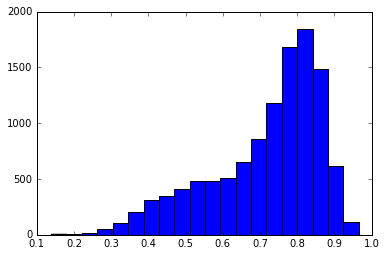

In [13]:
plt.hist(R,bins=20);

In [14]:
prediction.shape

(1000, 11350)

In [15]:
prediction = prediction.transpose([1,0])

In [16]:
num_samples = prediction.shape[1]
prediction = (prediction*np.outer(std_nonlandmark,np.ones(num_samples))) + np.outer(mean_nonlandmark,np.ones(num_samples))


In [17]:
df2 = pd.DataFrame(prediction)

In [18]:
df2.to_csv('/home/peter/Data/CMAP/test/prediction_ff.csv', header=None, index=False)

In [ ]:
"""
Rscript cmap_scoring_function.R --inf_ds prediction_ff.csv \
    --truth_ds truth.csv \
    --reference_scores refScores.csv \
    --out here

In [19]:
path='/home/peter/Data/CMAP/test/prediction_ff.csv'
data = pd.read_csv(path, header=None, dtype=np.float32)
test = data.as_matrix()
test.shape

(11350, 1000)

In [20]:
nonlandmarkpath='/home/peter/Data/CMAP/test/truth.csv'
data = pd.read_csv(nonlandmarkpath, header=None, dtype=np.float32)
truth = data.as_matrix()
truth.shape

(11350, 1000)

In [21]:
R = []
for i in range(prediction.shape[1]):
    R.append(stats.spearmanr(prediction[i,:], truth[i,:])[0])
np.mean(R)

0.73756263297012703